In [ ]:
import numpy as np
from time import perf_counter
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.utils import resample
from scipy.stats import norm

# ---------- helpers ----------
def sign_entropy_from_p(p, eps=1e-12):
    """Binary entropy H(p) for probability p of positive sign."""
    p = np.clip(p, eps, 1.0 - eps)
    return -(p * np.log(p) + (1 - p) * np.log(1 - p))

def bootstrap_ols_sign_entropy(X, y, B=1000, random_state=42):
    """
    Perform B bootstraps of OLS on (X, y), compute per-feature sign entropy.
    Returns (entropy_vector, wall_clock_seconds)
    """
    rng = np.random.RandomState(random_state)
    p = X.shape[1]
    signs = np.empty((B, p), dtype=np.int8)

    t0 = perf_counter()
    for b in range(B):
        Xb, yb = resample(X, y, replace=True, random_state=rng.randint(0, 10**9))
        coef = LinearRegression().fit(Xb, yb).coef_
        signs[b, :] = np.sign(coef)

    # probability a coefficient is positive across bootstraps
    p_pos = (signs > 0).mean(axis=0)
    se = sign_entropy_from_p(p_pos)
    wall = perf_counter() - t0
    return se, wall

def bayesian_ridge_sign_entropy(X, y):
    """
    Fit BayesianRidge once, compute sign entropy from posterior mean & variance.
    Returns (entropy_vector, wall_clock_seconds, mu, sigma)
    """
    t0 = perf_counter()
    br = BayesianRidge(compute_score=False)  # sklearn API
    br.fit(X, y)
    mu = br.coef_.ravel()
    # Posterior covariance of coefficients (Sigma): br.sigma_
    # For moderate p, we can take the diagonal safely:
    sigma = np.sqrt(np.clip(np.diag(br.sigma_), 1e-12, None))
    p_pos = 1.0 - norm.cdf(-mu / (sigma + 1e-12))
    se = sign_entropy_from_p(p_pos)
    wall = perf_counter() - t0
    return se, wall, mu, sigma

# ---------- main demo ----------
if __name__ == "__main__":
    # Synthetic data (tweak n_samples/n_features to your needs)
    n_samples = 10000
    n_features = 500
    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=25,
        noise=10.0,
        effective_rank=30,   # induces multicollinearity; remove or change if you like
        random_state=0
    )

    # Train/test split (timing only uses train; test is for sanity if you want later)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Standardize features (common and helps comparability)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test  = scaler.transform(X_test)

    # Compare times for several bootstrap sizes
    B_list = [100, 500, 1000, 2000]

    print(f"\nDataset: n={X_train.shape[0]}, p={X_train.shape[1]}")
    print("Timing includes ONLY the stability computation path for each method.\n")

    # One BayesianRidge fit (single run, since it does not depend on B)
    se_bayes, t_bayes, mu_bayes, sig_bayes = bayesian_ridge_sign_entropy(X_train, y_train)
    print(f"BayesianRidge:  1 fit  -> time = {t_bayes:.3f} s")

    # Bootstrap OLS for different B
    for B in B_list:
        se_boot, t_boot = bootstrap_ols_sign_entropy(X_train, y_train, B=B, random_state=42)
        # Optional: measure agreement between bootstrap SE and Bayesian SE
        corr = np.corrcoef(se_boot, se_bayes)[0, 1]
        print(f"Bootstrap OLS: B={str(B).rjust(4)} -> time = {t_boot:.3f} s | SE corr with Bayes = {corr:.3f}")

    # If you also want to print quick summaries of entropies:
    print("\nMedian sign entropy (Bayesian vs. last bootstrap run above):")
    print(f"  Bayes median SE:     {np.median(se_bayes):.4f}")
    print(f"  Bootstrap median SE: {np.median(se_boot):.4f}")

In [ ]:
import numpy as np
from scipy.spatial.distance import cosine

def locality_weight(x, z, sigma=1.0):
    """
    Compute exp(-D(x,z)^2 / sigma^2),
    where D is the cosine distance between x and z.
    """
    # Cosine distance (1 - cosine similarity)
    dist = cosine(x, z)
    weight = np.exp(-(dist ** 2) / (sigma ** 2))
    return dist, weight

# Example usage
x = np.array([1, 2, 3])
z = np.array([1, 2, 2.5])

for sigma in [0.5, 1.0, 2.0]:
    dist, w = locality_weight(x, z, 0.25)
    print(f"σ={sigma}, Cosine distance={dist:.4f}, Weight={w:.4f}")


σ=0.5, Cosine distance=0.0040, Weight=0.9997
σ=1.0, Cosine distance=0.0040, Weight=0.9997
σ=2.0, Cosine distance=0.0040, Weight=0.9997


In [ ]:
dist = 0
weight = np.exp(-(dist ** 2) / (1 ** 2))
print(weight)

1.0


In [2]:
##### BayCoFE relevant features

import copy

import numpy as np
import matplotlib.pyplot as plt
import gc
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np
import itertools
import random
import pandas as pd
from scipy.stats import norm, gaussian_kde
from sklearn.neighbors import KernelDensity
import pickle
from sklearn.linear_model import Ridge
from scipy.stats import norm
import os
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import time


In [3]:
def calculate_entropy(data):
    if np.var(data) == 0:
        return 0

    scipy_kernel = gaussian_kde(data)

    #  We calculate the bandwidth for later use
    optimal_bandwidth = scipy_kernel.factor * np.std(data)

    # Calculate KDE for the entire dataset
    kde = gaussian_kde(data, bw_method=optimal_bandwidth)

    # Create a range of values to represent the KDE
    x = np.linspace(np.min(data), np.max(data), 1000)

    # Evaluate the density at each point in the range
    density = kde(x)

    # Normalize the density function
    normalized_density = density / np.sum(density * (x[1] - x[0]))

    # Calculate the probabilities of positive and negative values
    positive_probability = np.sum(normalized_density[x >= 0] * (x[1] - x[0]))
    negative_probability = np.sum(normalized_density[x < 0] * (x[1] - x[0]))

    if positive_probability == 0 or negative_probability == 0:
        sign_entropy = 0
    else:
        sign_entropy = -positive_probability * np.log2(positive_probability) \
                       - negative_probability * np.log2(negative_probability)

    return sign_entropy


def calculate_entropies(result_matrix):
    sign_entropies = []
    for column in range(result_matrix.shape[1]):
        data = result_matrix[:, column]
        sign_entropy = calculate_entropy(data)
        sign_entropies.append(sign_entropy)

    sign_entropies = np.array(sign_entropies)

    return sign_entropies


def calculate_entropy_dist(mu, sigma):
    p_negative = norm.cdf(0, mu, sigma)
    p_positive = 1 - p_negative

    # Avoiding log(0) issue by adding a small epsilon where probabilities are 0
    if p_positive == 0 or p_positive == 1:
        entropy = 0
    else:
        entropy = -(p_positive * np.log2(p_positive) + p_negative * np.log2(p_negative))

    return entropy


def sefe_select_features(X_train, y_train, num_bootstrap=1000, slack=0.0, num_iter=10, **kwargs):
    model = kwargs['estimator']
    tolerance_limit = 3
    tolerance_cur=0
    final_coeffs = np.zeros((num_bootstrap, X_train.shape[1]))

    train_mat_sel_idx = np.zeros(X_train.shape[1])
    sign_entropies_final = np.zeros(X_train.shape[1])
    iter_info = []
    for iter in range(num_iter):
        zero_indices = np.where(train_mat_sel_idx == 0)[0] # get only those indices which had zero entropy from previous run
        start_time = time.time()
        if len(zero_indices)==0:
            print("No feature of zero entropy")
            break

        coeffs_bs = []
        for i in range(num_bootstrap):
            indices_bs = random.choices(range(X_train.shape[0]), k=X_train.shape[0])
            X_sample, y_sample = X_train[indices_bs][:, zero_indices], y_train[indices_bs]
            model.fit(X_sample, y_sample)
            coeffs_bs.append(model.coef_)

        coeffs_bs = np.array(coeffs_bs)

        sign_entropies = []
        for column in range(coeffs_bs.shape[1]):
            data = coeffs_bs[:, column]
            sign_entropy = calculate_entropy(data)
            sign_entropies.append(sign_entropy)

        sign_entropies = np.array(sign_entropies)

        #non_zero_indices = np.where(sign_entropies != 0)[0]
        #zero_ent_indices = np.where(sign_entropies == 0)[0]

        non_zero_indices = np.where(sign_entropies > (0+slack))[0]
        zero_ent_indices = np.where(sign_entropies <= (0+slack))[0]

        original_0_indices = np.where(train_mat_sel_idx == 0)[0]
        mapped_non0_indices = original_0_indices[non_zero_indices]

        if not np.size(mapped_non0_indices) == 0:
            train_mat_sel_idx[mapped_non0_indices] = 1
            sign_entropies_final = np.zeros(X_train.shape[1])  # reinitialize this as we need to return the final sign entropies
            sign_entropies_final[mapped_non0_indices] = sign_entropies[sign_entropies > slack]
            tolerance_cur = 0
            end_time = time.time()
            iter_info.append((iter, copy.copy(sign_entropies_final), copy.copy(train_mat_sel_idx), (end_time - start_time)))
        else:
            if tolerance_cur == 0:
                final_coeffs = coeffs_bs
                tolerance_cur = tolerance_cur + 1
                end_time = time.time()
                iter_info.append((iter, copy.copy(sign_entropies_final), copy.copy(train_mat_sel_idx), (end_time - start_time)))
            else:
                if tolerance_cur < tolerance_limit:
                    tolerance_cur = tolerance_cur + 1  # re-evaluating n times after a good run
                    end_time = time.time()
                    iter_info.append((iter, copy.copy(sign_entropies_final), copy.copy(train_mat_sel_idx), (end_time - start_time)))
                else:
                    sign_entropies_final = np.zeros(X_train.shape[1])  # reinitialize this as we need to return the final sign entropies
                    sign_entropies_final[mapped_non0_indices] = sign_entropies[sign_entropies > slack]
                    end_time = time.time()
                    iter_info.append((iter, copy.copy(sign_entropies_final), copy.copy(train_mat_sel_idx), (end_time - start_time)))
                    break  # terminate the feature elimination process

    top_idx = np.array(np.where(train_mat_sel_idx==0)[0])
    if (len(top_idx)) == 0:
        top_idx = np.arange(0, len(train_mat_sel_idx), step=1)

    return top_idx, np.mean(sign_entropies_final), iter_info


def baycofe_select_features(X_train, y_train, slack=0.001, num_iter = 10, **kwargs): #housing: 0.001 energy: 0.025 superconductivity: 0.005
    model = kwargs['estimator']

    train_mat_sel_idx = np.zeros(X_train.shape[1])
    sign_entropies_final = np.zeros(X_train.shape[1])
    iter_info = []
    for iter in range(num_iter):
        start_time = time.time()
        zero_indices = np.where(train_mat_sel_idx == 0)[0] # get only those indices which had zero entropy from previous run

        if len(zero_indices)==0:
            print("No feature of zero entropy")
            break

        X_selected = X_train[:, zero_indices]
        model.fit(X_selected, y_train)

        beta_means = model.coef_
        beta_stds = np.sqrt(np.diag(model.sigma_))

        sign_entropies = []
        for beta_mean, beta_std in zip(beta_means, beta_stds):
            sign_entropies.append(calculate_entropy_dist(beta_mean, beta_std))

        sign_entropies = np.array(sign_entropies)
        non_zero_indices = np.where(sign_entropies > slack)[0]
        zero_ent_indices = np.where(sign_entropies <= slack)[0]

        original_0_indices = np.where(train_mat_sel_idx == 0)[0]
        mapped_non0_indices = original_0_indices[non_zero_indices]

        if not np.size(mapped_non0_indices) == 0:
            train_mat_sel_idx[mapped_non0_indices] = 1
            sign_entropies_final = np.zeros(X_train.shape[1])  # reinitialize this as we need to return the final sign entropies
            sign_entropies_final[mapped_non0_indices] = sign_entropies[sign_entropies > slack]
            end_time = time.time()
            iter_info.append((iter, copy.deepcopy(sign_entropies_final), copy.deepcopy(train_mat_sel_idx), (end_time - start_time)))
        else:
            sign_entropies_final = np.zeros(X_train.shape[1])  # reinitialize this as we need to return the final sign entropies
            sign_entropies_final[mapped_non0_indices] = sign_entropies[sign_entropies > slack]
            end_time = time.time()
            iter_info.append((iter, copy.deepcopy(sign_entropies_final), copy.deepcopy(train_mat_sel_idx), (end_time - start_time)))
            break

    top_idx = np.array(np.where(train_mat_sel_idx==0)[0])
    if (len(top_idx)) == 0:
        top_idx = np.arange(0, len(train_mat_sel_idx), step=1)

    return top_idx, np.mean(sign_entropies_final), iter_info


def rfe_select_features(X_train, y_train, **kwargs):
    estimator = kwargs['estimator']
    max_k = X_train.shape[1]  # Maximum number of features

    param_grid = {'n_features_to_select': range(1, max_k + 1)}  # Define range of k values
    selector = RFE(estimator=estimator)
    grid_search = GridSearchCV(selector, param_grid, cv=5)  # 5-fold cross-validation
    grid_search.fit(X_train, y_train)  # X_train and y_train are your training data

    best_k = grid_search.best_params_['n_features_to_select']
    selected_features = [i for i, selected in enumerate(grid_search.best_estimator_.support_) if selected]

    return selected_features


def forward_select_features(X_train, y_train, **kwargs):
    estimator = kwargs['estimator']
    n_features_to_select = kwargs.get('n_features_to_select', X_train.shape[1])

    selector = SequentialFeatureSelector(estimator=estimator, k_features=(1, X_train.shape[1]), cv=5, forward=True,
                                         floating=False)
    selector.fit(X_train, y_train)
    return selector.k_feature_idx_


def sbs_select_features(X_train, y_train, **kwargs):
    estimator = kwargs['estimator']
    n_features_to_select = kwargs.get('n_features_to_select', X_train.shape[1])
    selector = SequentialFeatureSelector(estimator=estimator, k_features=(1, X_train.shape[1]), cv=5, forward=False,
                                         floating=False)
    selector.fit(X_train, y_train)
    return selector.k_feature_idx_


def bidirectional_select_features(X_train, y_train, **kwargs):
    estimator = kwargs['estimator']
    n_features_to_select = kwargs.get('n_features_to_select', X_train.shape[1])
    selector = SequentialFeatureSelector(estimator=estimator, k_features=(1, X_train.shape[1]), cv=5, forward=True,
                                         floating=True)
    selector.fit(X_train, y_train)
    return selector.k_feature_idx_

In [4]:
# Function to compute Intersection-over-Union (IoU) between two sets.
def iou(set1, set2):
    if len(set1) == 0 and len(set2) == 0:
        return 1.0
    intersection = np.intersect1d(set1, set2)
    union = np.union1d(set1, set2)
    return len(intersection) / len(union)

# Function to compute a pairwise IoU matrix given a list of feature sets.
def compute_pairwise_iou(feature_sets):
    num = len(feature_sets)
    iou_matrix = np.zeros((num, num))
    for i in range(num):
        for j in range(num):
            iou_matrix[i, j] = iou(feature_sets[i], feature_sets[j])
    return iou_matrix

def generate_synthetic_data(n_true=10, m_noise=20, num_samples=1500, noise_type='gaussian', noise_level=0.1):
    #np.random.seed(42)  # Reproducibility

    # Generate true features affecting y
    X_true = np.random.randn(num_samples, n_true)

    # Generate true coefficients
    beta = np.random.randn(n_true)

    # Adjust noise levels for fair comparison
    if noise_type == 'gaussian':
        noise = np.random.normal(0, noise_level, X_true.shape)  # Standard deviation = noise_level
    elif noise_type == 'uniform':
        noise = np.random.uniform(-np.sqrt(3) * noise_level, np.sqrt(3) * noise_level, X_true.shape)
        # Scaled so variance matches Gaussian: Var(U(a,b)) = (b-a)^2 / 12
    elif noise_type == 'laplace':
        noise = np.random.laplace(0, noise_level / np.sqrt(2), X_true.shape)
        # Scale adjusted so variance matches Gaussian: Var(Laplace(0, b)) = 2b^2
    elif noise_type == 'heteroscedastic':
        noise = noise_level * (1 + np.abs(X_true)) * np.random.randn(*X_true.shape)
        # Noise increases with value
    elif noise_type == 'correlated':
        noise = noise_level * np.sin(np.linspace(0, np.pi, num_samples)).reshape(-1, 1)
        # Sinusoidal correlated noise
    else:
        raise ValueError("Invalid noise type!")

    # Add noise to true features
    X_true_noisy = X_true + noise

    # Generate target variable y with additional Gaussian observation noise
    #y = X_true_noisy @ beta + np.random.normal(0, noise_level, num_samples) #0

    y = X_true @ beta + np.random.normal(0, noise_level, num_samples) #1

    # Artificial noisy features (completely random)
    X_noise = np.random.randn(num_samples, m_noise)

    # Concatenate true and noisy features
    X = np.hstack((X_true_noisy, X_noise))

    return X, y, np.arange(n_true)


# Function to evaluate feature selection
def evaluate_feature_selection_old(method_name, selected_features, true_features, total_features):
    selected_features = set(selected_features)
    true_features = set(true_features)

    # Compute IoU
    intersection = len(selected_features & true_features)
    union = len(selected_features | true_features)
    iou = intersection / union if union != 0 else 0

    # Compute False Positive Rate (FPR)
    false_positives = len(selected_features - true_features) / (total_features - len(true_features))

    # Compute False Negative Rate (FNR)
    false_negatives = len(true_features - selected_features) / len(true_features)

    print(f"{method_name}: IoU={iou:.3f}, FPR={false_positives:.3f}, FNR={false_negatives:.3f}")

    return iou, false_positives, false_negatives

def evaluate_feature_selection(method_name, selected_features, true_features, total_features):
    selected_features = set(selected_features)
    true_features = set(true_features)

    # --- Counts ---
    TP = len(selected_features & true_features)  # correctly selected
    FP = len(selected_features - true_features)  # irrelevant selected
    FN = len(true_features - selected_features)  # missed relevant
    TN = total_features - (TP + FP + FN)         # correctly rejected

    # --- IoU ---
    union = TP + FP + FN
    iou = TP / union if union != 0 else 0

    # --- FPR, FNR ---
    false_positives = FP / (FP + TN) if (FP + TN) > 0 else 0
    false_negatives = FN / (FN + TP) if (FN + TP) > 0 else 0

    # --- Precision, Recall, F1 ---
    precision_pos = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall_pos    = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_pos = 2 * precision_pos * recall_pos / (precision_pos + recall_pos) if (precision_pos + recall_pos) > 0 else 0

    precision_neg = TN / (TN + FN) if (TN + FN) > 0 else 0
    recall_neg    = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1_neg = 2 * precision_neg * recall_neg / (precision_neg + recall_neg) if (precision_neg + recall_neg) > 0 else 0

    macro_f1 = (f1_pos + f1_neg) / 2

    print(f"{method_name}: IoU={iou:.3f}, FPR={false_positives:.3f}, FNR={false_negatives:.3f}, f1_pos={f1_pos:.3f}")

    return iou, false_positives, false_negatives, f1_pos

In [5]:
# Run the evaluation
import pickle
import numpy as np
from sklearn.linear_model import BayesianRidge
import random


if __name__ == '__main__':
    # Number of runs (independent datasets)
    num_runs = 20

    # Define noise levels (sigma values)
    sigma_kernel_values = [0.001, 0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1]
    noise_type = "correlated"
    # Dictionary to store results
    results = {}
    selected_features_dict = {}

    for sigma in sigma_kernel_values:
        print(f"\nRunning feature selection for sigma={sigma}...")

        for run in np.arange(0, num_runs, step=1):
            print(f"Run {run+1}/{num_runs} for sigma={sigma}")

            # Generate a fresh dataset for this run
            #datasets, true_features = generate_synthetic_data(sigma_kernel=[sigma])
            #X, y, _ = datasets[0]  # Extract the generated dataset
            num_true = np.random.randint(1, 11)
            num_noise = np.random.randint(10, 41)
            print(f"Num True:{num_true} Num Noisy: {num_noise}")
            X,y, true_features = generate_synthetic_data(n_true=num_true, m_noise=num_noise, noise_type=noise_type, noise_level=sigma)

            # 1. CoFE (Frequentist)
            estimator = BayesianRidge(max_iter=300, lambda_init=1e-10, fit_intercept=True, compute_score=True)
            sel_features_cofe, _, _ = sefe_select_features(X, y, slack=0.0454, estimator=estimator, num_bootstrap=1000)

            # Append results instead of overwriting
            results.setdefault(f"CoFE_sigma={sigma}", []).append(
                evaluate_feature_selection("CoFE", sel_features_cofe, true_features, X.shape[1])
            )
            selected_features_dict.setdefault(f"CoFE_sigma={sigma}", []).append({
                "selected": sel_features_cofe,
                "n_true": num_true,
                "m_noise": num_noise
            })


            # 2. Bay-CoFE
            sel_features_baycofe, _, _ = baycofe_select_features(X, y, slack=0.0454, estimator=estimator)
            results.setdefault(f"Bay-CoFE_sigma={sigma}", []).append(
                evaluate_feature_selection("Bay-CoFE", sel_features_baycofe, true_features, X.shape[1])
            )
            selected_features_dict.setdefault(f"Bay-CoFE_sigma={sigma}", []).append({
                  "selected": sel_features_baycofe,
                  "n_true": num_true,
                  "m_noise": num_noise
            })


            # 3. RFE (Recursive Feature Elimination)
            sel_features_rfe = rfe_select_features(X, y, estimator=estimator)
            results.setdefault(f"RFE_sigma={sigma}", []).append(
                evaluate_feature_selection("RFE", sel_features_rfe, true_features, X.shape[1])
            )
            #selected_features_dict.setdefault(f"RFE_sigma={sigma}", []).append(sel_features_rfe)
            selected_features_dict.setdefault(f"RFE_sigma={sigma}", []).append({
                  "selected": sel_features_rfe,
                  "n_true": num_true,
                  "m_noise": num_noise
            })


            # 4. Sequential Forward Selection (SFS)
            sel_features_sfs = forward_select_features(X, y, estimator=estimator)
            results.setdefault(f"SFS_sigma={sigma}", []).append(
                evaluate_feature_selection("SFS", sel_features_sfs, true_features, X.shape[1])
            )
            #selected_features_dict.setdefault(f"SFS_sigma={sigma}", []).append(sel_features_sfs)
            selected_features_dict.setdefault(f"SFS_sigma={sigma}", []).append({
                  "selected": sel_features_sfs,
                  "n_true": num_true,
                  "m_noise": num_noise
            })


            # 5. Sequential Backward Selection (SBS)
            sel_features_sbs = sbs_select_features(X, y, estimator=estimator)
            results.setdefault(f"SBS_sigma={sigma}", []).append(
                evaluate_feature_selection("SBS", sel_features_sbs, true_features, X.shape[1])
            )
            #selected_features_dict.setdefault(f"SBS_sigma={sigma}", []).append(sel_features_sbs)
            selected_features_dict.setdefault(f"SBS_sigma={sigma}", []).append({
                  "selected": sel_features_sbs,
                  "n_true": num_true,
                  "m_noise": num_noise
            })

            # 6. Bidirectional Feature Selection
            sel_features_bidir = bidirectional_select_features(X, y, estimator=estimator)
            results.setdefault(f"Bidirectional_sigma={sigma}", []).append(
                evaluate_feature_selection("Bidirectional", sel_features_bidir, true_features, X.shape[1])
            )
            #selected_features_dict.setdefault(f"Bidirectional_sigma={sigma}", []).append(sel_features_bidir)
            selected_features_dict.setdefault(f"Bidirectional_sigma={sigma}", []).append({
                  "selected": sel_features_bidir,
                  "n_true": num_true,
                  "m_noise": num_noise
            })


Running feature selection for sigma=0.001...
Run 1/20 for sigma=0.001
Num True:3 Num Noisy: 35
CoFE: IoU=1.000, FPR=0.000, FNR=0.000, f1_pos=1.000
Bay-CoFE: IoU=1.000, FPR=0.000, FNR=0.000, f1_pos=1.000
RFE: IoU=1.000, FPR=0.000, FNR=0.000, f1_pos=1.000
SFS: IoU=0.333, FPR=0.171, FNR=0.000, f1_pos=0.500
SBS: IoU=0.333, FPR=0.171, FNR=0.000, f1_pos=0.500
Bidirectional: IoU=0.333, FPR=0.171, FNR=0.000, f1_pos=0.500
Run 2/20 for sigma=0.001
Num True:3 Num Noisy: 18
CoFE: IoU=1.000, FPR=0.000, FNR=0.000, f1_pos=1.000
Bay-CoFE: IoU=0.750, FPR=0.056, FNR=0.000, f1_pos=0.857
RFE: IoU=0.600, FPR=0.111, FNR=0.000, f1_pos=0.750
SFS: IoU=0.429, FPR=0.222, FNR=0.000, f1_pos=0.600
SBS: IoU=0.429, FPR=0.222, FNR=0.000, f1_pos=0.600
Bidirectional: IoU=0.429, FPR=0.222, FNR=0.000, f1_pos=0.600
Run 3/20 for sigma=0.001
Num True:3 Num Noisy: 31
CoFE: IoU=1.000, FPR=0.000, FNR=0.000, f1_pos=1.000
Bay-CoFE: IoU=0.750, FPR=0.032, FNR=0.000, f1_pos=0.857
RFE: IoU=0.750, FPR=0.032, FNR=0.000, f1_pos=0.857
S

In [6]:
# Save results
pkl_filename = f"/content/drive/MyDrive/PhD/Results/bay_cofe_new/relevant_features/20_runs_feature_relevance_evaluation_{noise_type}1.pkl"
with open(pkl_filename, 'wb') as f:
  pickle.dump({"results": results, "sel_features": selected_features_dict}, f)

In [ ]:
p_positive = 0.995
p_negative = 1- p_positive
-(p_positive * np.log2(p_positive) + p_negative * np.log2(p_negative))

np.float64(0.04541469233379414)

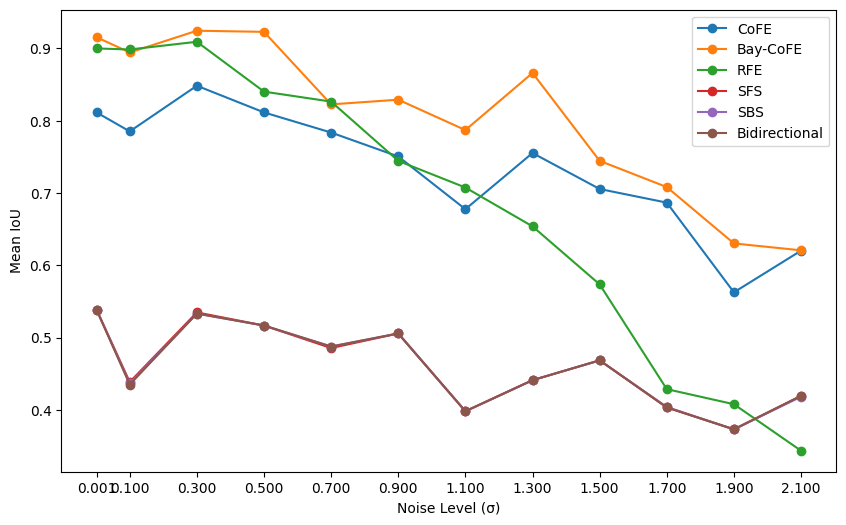

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt


pkl_filename = f"/content/drive/MyDrive/PhD/Results/bay_cofe_new/relevant_features/20_runs_feature_relevance_evaluation_{noise_type}1.pkl"
with open(pkl_filename, 'rb') as f:
    data = pickle.load(f)

results = data['results']

# Extract unique noise levels
sigma_values = sigma_kernel_values #sorted(set(float(key.split('=')[-1]) for key in results.keys()))

# Initialize dictionary to store mean IoU for each method
mean_iou_dict = {method.split('_')[0]: [] for method in results.keys()}

# Compute mean IoU for each method across different noise levels
for sigma in sigma_values:
    for method in mean_iou_dict.keys():
        key = f"{method}_sigma={sigma}"
        if key in results:
            mean_iou = np.mean([x[0] for x in results[key]])  # IoU is the first value in evaluate_feature_selection()
            mean_iou_dict[method].append(mean_iou)
        else:
            mean_iou_dict[method].append(None)  # Handle missing data

# Plot Mean IoU vs. Noise Level for Each Method
plt.figure(figsize=(10, 6))

for method, mean_ious in mean_iou_dict.items():
    plt.plot(sigma_values, mean_ious, marker='o', label=method)

plt.xticks(sigma_values)   # set ticks exactly at your sigma values


plt.xlabel("Noise Level (σ)")
plt.ylabel("Mean IoU")
#plt.title("Mean IoU vs. Noise Level for Feature Selection Methods")
plt.legend()
#plt.savefig('plots/true_feature_extraction/true_feature_iou_gaussian1.png')
plt.show()
